<a href="https://colab.research.google.com/github/johnsDevassy/Worked_Projects/blob/master/Project_tumor_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Loading modules

In [ ]:
from zipfile import ZipFile
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import os
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from keras.layers import *
import random
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


#loading files

In [ ]:
zip=ZipFile('/content/drive/MyDrive/Xen/project tumor/1512427.zip','r')
zip.extractall()

In [ ]:
paths=['/content/brainTumorDataPublic_1-766.zip','/content/brainTumorDataPublic_1533-2298.zip','/content/brainTumorDataPublic_2299-3064.zip','/content/brainTumorDataPublic_767-1532.zip']
for one in range(len(paths)):
  zip=ZipFile(paths[one],'r')
  zip.extractall('/content/'+str(one))

#Opening just an image

In [ ]:
path_to_1='/content/0/1.mat'
F=h5py.File(path_to_1,'r')

In [ ]:
F.keys()

<KeysViewHDF5 ['cjdata']>

In [ ]:
cjdata=F['cjdata']

In [ ]:
F['cjdata'].keys()

<KeysViewHDF5 ['PID', 'image', 'label', 'tumorBorder', 'tumorMask']>

In [ ]:
np.array(cjdata.get('image')).shape

(512, 512)

In [ ]:
np.array(cjdata.get('PID'))


array([[49],
       [48],
       [48],
       [51],
       [54],
       [48]], dtype=uint16)

In [ ]:
np.unique(np.array(cjdata.get('tumorMask')))
#0 and 1 so we can give boolean values for this array

array([0, 1], dtype=uint8)

In [ ]:
image=np.array(cjdata.get('image')).astype(np.float64)

In [ ]:
image

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
im=Image.fromarray(image)

In [ ]:
np.asarray(im)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

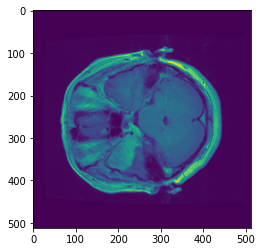

In [ ]:
plt.imshow(image)

#Lets load all

We have to create 5 numpy arrays to store data from each .mat file

In [ ]:
height=128
width=128
pid=[]
label=[]
tborder=[]
tmask=np.zeros((3064,height,width),dtype=np.bool)
pimg=np.zeros((3064,height,width),dtype=np.float64)
#A for loop for all files
tot=0
for i in range(4):
  for files in os.listdir('/content/'+str(i)):
    F=h5py.File('/content/'+str(i)+'/'+files,'r')
    cjdata=F['cjdata']
    #image
    #torsf
    p_image_in_box=cjdata.get('image')
    p_image_in_box=Image.fromarray(np.array(p_image_in_box).astype(np.float64))
    p_image_in_box=p_image_in_box.resize((128,128))
    pimg[tot]=np.array(p_image_in_box).astype(np.float64)
      
    #id
    p_id_in_box=cjdata.get('PID')
    p_id_in_box= ''.join(chr(element) for element in p_id_in_box )
    pid.append(p_id_in_box)
    #label
    l_in_box=cjdata.get('label')
    label.append([i for i in l_in_box][0][0])
    #tumorborder
    p_tborder_in_box=cjdata.get('tumorBorder')
    tborder.append(np.array(p_tborder_in_box[0]))
    #tumorMask
    p_tmask_in_box=cjdata.get('tumorMask')
    p_tmask_in_box=Image.fromarray(np.array(p_tmask_in_box).astype(np.float64))
    p_tmask_in_box=p_tmask_in_box.resize((128,128))
    tmask[tot]=np.array(p_tmask_in_box).astype(np.float64)
    
    tot+=1
print(label)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0,

#now lets understand data structure

In [ ]:
len(set(pid))

233

(128, 128)

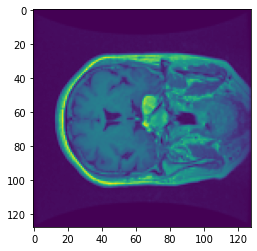

In [ ]:
plt.imshow(pimg[0])
pimg[0].shape

In [ ]:
pimg.shape

(3064, 128, 128)

In [ ]:
print(label.count(3),'3')
print(label.count(2),'2')
print(label.count(1),'1')

930 3
1426 2
708 1


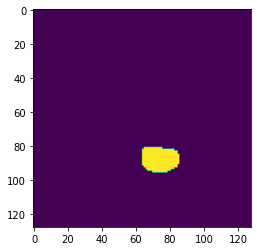

In [ ]:
plt.imshow(tmask[1])

In [ ]:
np.unique(tmask[1])

array([False,  True])

In [ ]:
np.expand_dims(np.full((128,128),5),axis=(2)).shape

(128, 128, 1)

Seems like changing dimensions doest effect it completely . Thats good

#lets create 3 new dataset for 3 each classes

In [ ]:
set_1x=np.zeros((708,128,128,1),dtype=np.float64)
set_2x=np.zeros((1426,128,128,1),dtype=np.float64)
set_3x=np.zeros((930,128,128,1),dtype=np.float64)
set_1y=np.zeros((708,128,128,1),dtype=np.float64)
set_2y=np.zeros((1426,128,128,1),dtype=np.float64)
set_3y=np.zeros((930,128,128,1),dtype=np.float64)
c1=0
c2=0
c3=0
labels_tot1=np.full((708),1,dtype=int)
labels_tot2=np.full((1426),2,dtype=int)
labels_tot3=np.full((930),3,dtype=int)
for i in range(3064):
  if label[i]==1:
    set_1x[c1]=np.expand_dims(pimg[i],axis=(2))
    set_1y[c1]=np.expand_dims(tmask[i],axis=(2))
    label
    c1+=1
  elif label[i]==2:
    set_2x[c2]=np.expand_dims(pimg[i],axis=(2))
    set_2y[c2]=np.expand_dims(tmask[i],axis=(2))
    c2+=1
  else:
    set_3x[c3]=np.expand_dims(pimg[i],axis=(2))
    set_3y[c3]=np.expand_dims(tmask[i],axis=(2))
    c3+=1

34


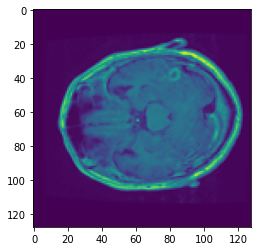

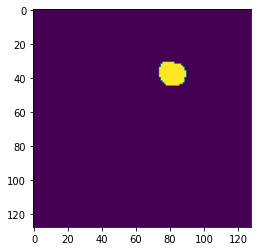

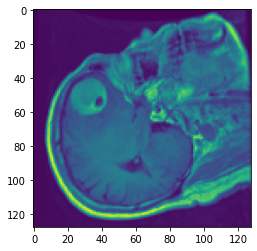

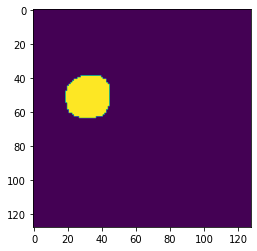

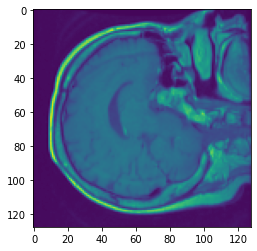

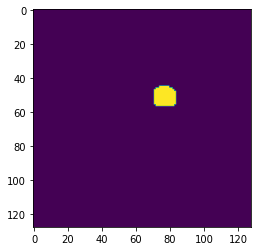

411


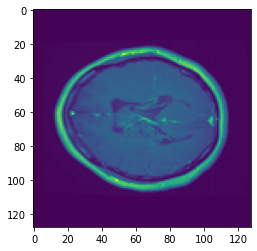

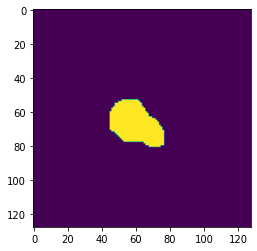

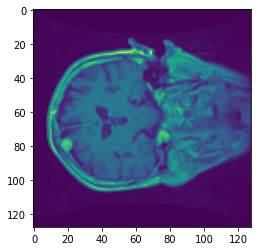

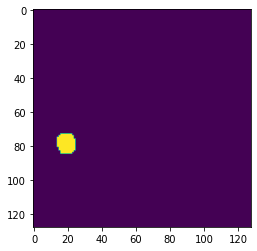

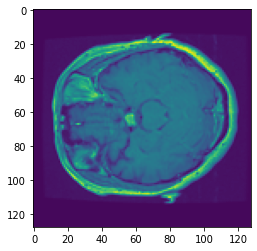

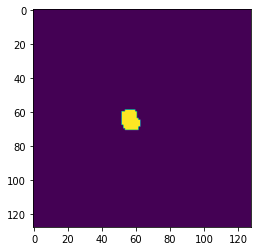

139


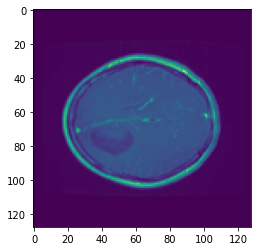

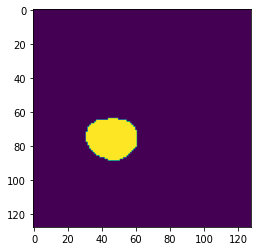

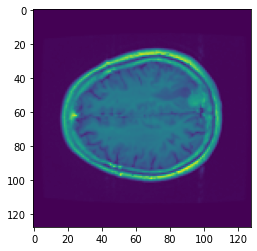

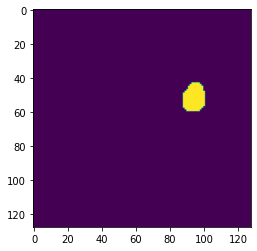

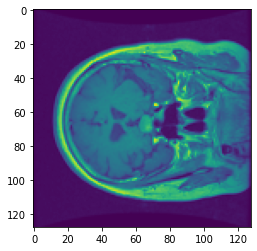

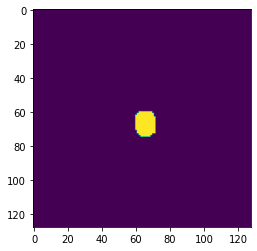

213


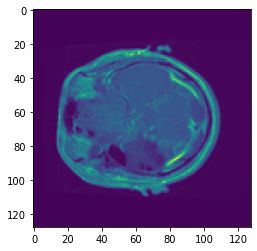

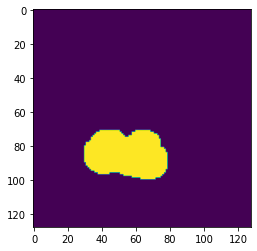

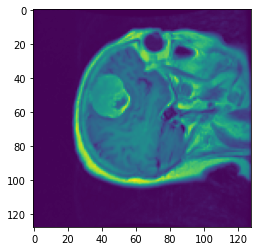

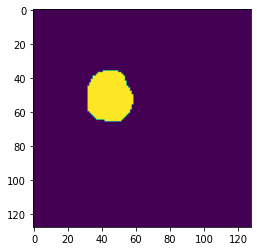

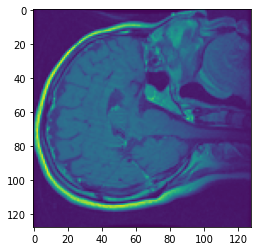

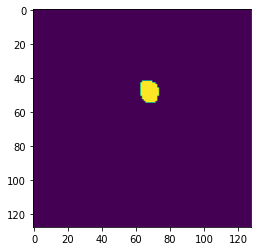

430


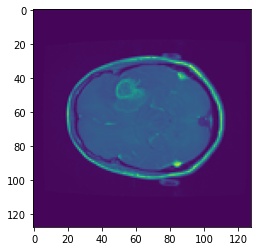

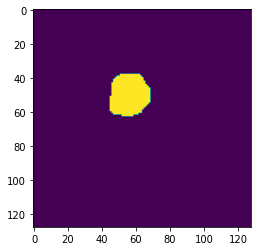

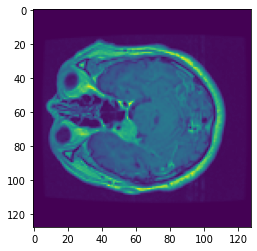

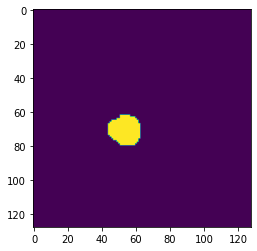

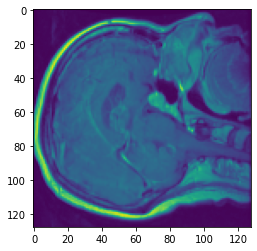

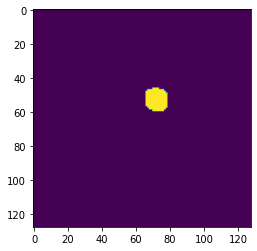

69


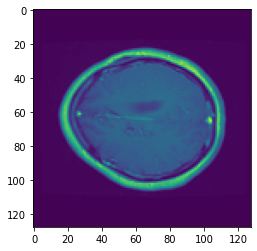

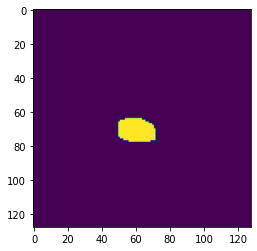

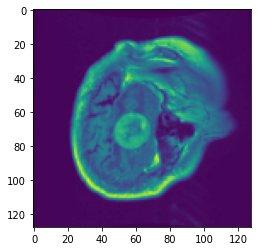

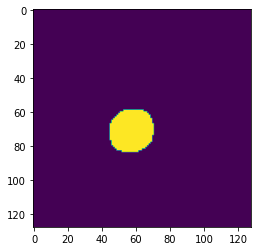

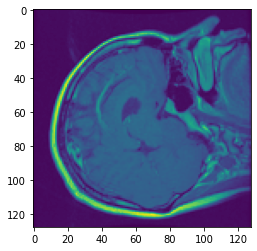

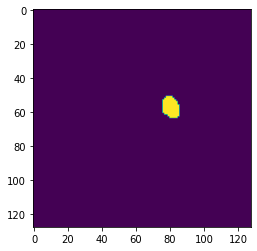

72


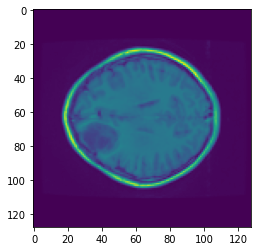

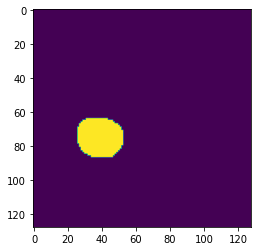

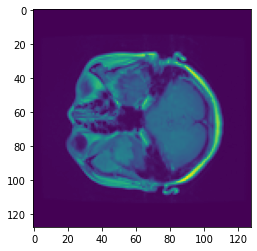

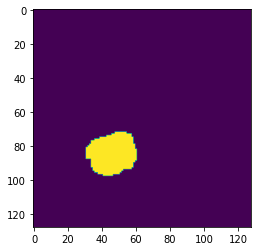

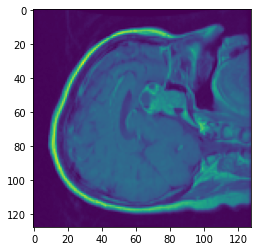

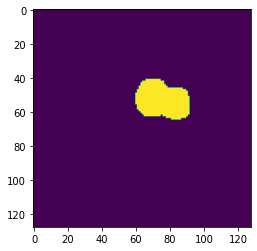

200


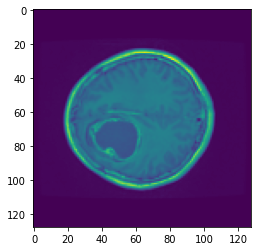

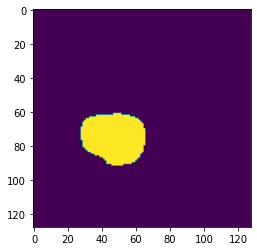

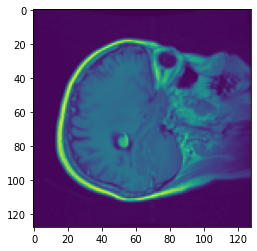

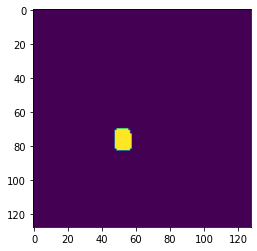

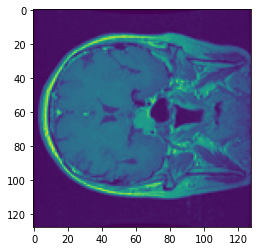

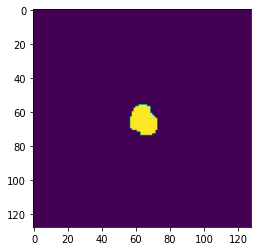

363


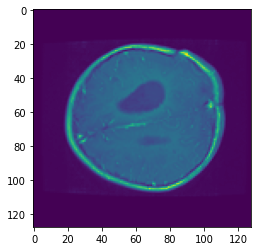

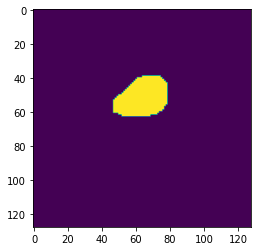

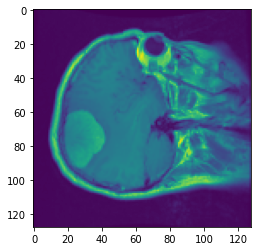

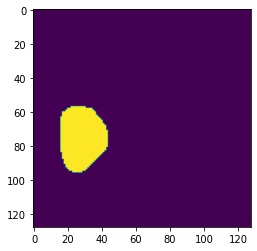

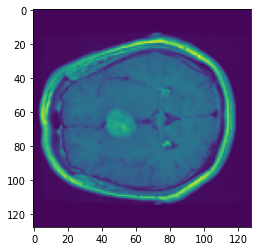

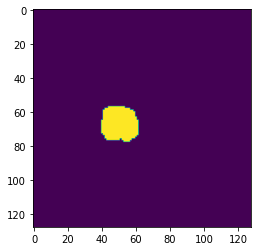

545


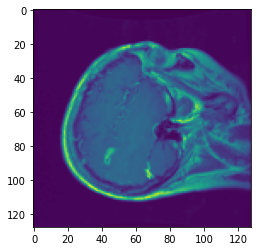

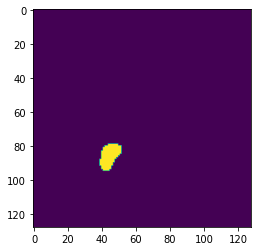

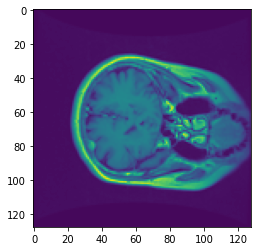

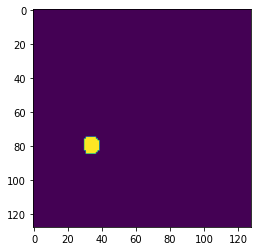

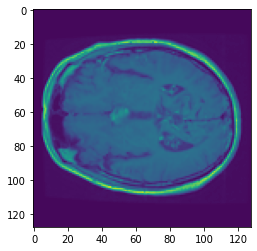

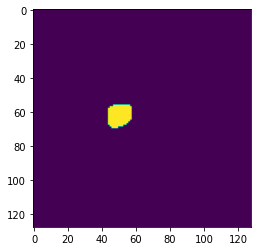

In [ ]:
for i in range(10):
  thing=random.randint(0,708)
  print(thing)
  plt.imshow(set_2x[thing].reshape((128,128)))
  plt.show()
  plt.imshow(set_2y[thing].reshape((128,128)))
  plt.show()
  plt.imshow(set_1x[thing].reshape((128,128)))
  plt.show()
  plt.imshow(set_1y[thing].reshape((128,128)))
  plt.show()
  plt.imshow(set_3x[thing].reshape((128,128)))
  plt.show()
  plt.imshow(set_3y[thing].reshape((128,128)))
  plt.show()

In [ ]:
np.unique(set_1y[1])

array([0., 1.])

#Working model segement only


In [ ]:
#making the set ready


In [ ]:
from keras.models import Model, load_model

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:


filepath = "model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

callbacks_list = [earlystopper, checkpoint]

history = model.fit(set_1x, set_1y, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=callbacks_list)

Epoch 1/50
40/40 [==============================] - 39s 166ms/step - loss: 0.4346 - val_loss: 0.1065

Epoch 00001: val_loss improved from inf to 0.10654, saving model to model.h5
Epoch 2/50
40/40 [==============================] - 4s 107ms/step - loss: 0.1002 - val_loss: 0.0964

Epoch 00002: val_loss improved from 0.10654 to 0.09640, saving model to model.h5
Epoch 3/50
40/40 [==============================] - 4s 107ms/step - loss: 0.0905 - val_loss: 0.0843

Epoch 00003: val_loss improved from 0.09640 to 0.08430, saving model to model.h5
Epoch 4/50
40/40 [==============================] - 4s 106ms/step - loss: 0.0837 - val_loss: 0.0852

Epoch 00004: val_loss did not improve from 0.08430
Epoch 5/50
40/40 [==============================] - 4s 106ms/step - loss: 0.0693 - val_loss: 0.0671

Epoch 00005: val_loss improved from 0.08430 to 0.06705, saving model to model.h5
Epoch 6/50
40/40 [==============================] - 4s 106ms/step - loss: 0.0531 - val_loss: 0.0575

Epoch 00006: val_loss 

#model2 not working

In [ ]:
import tensorflow as tf


IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1


#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
model.fit(set_1x,set_1y,verbose=1,epochs=10,validation_split=.2)

#Prediction sample


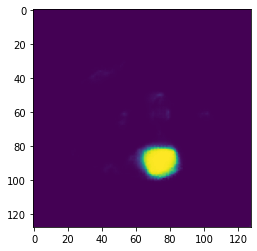

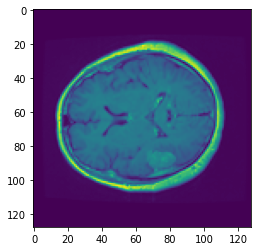

In [ ]:
rs=model.predict(set_1x[0:3])
plt.imshow(rs[1].reshape((128,128)))
plt.show()
plt.imshow(set_1x[1].reshape((128,128)))

plt.show()

#counting

Before train test split we have to create a dataframe to do the train test split sucessfully.

new_df=[X_train,y_train] andn new_y=label

In [ ]:
label=np.array(label)
label.shape

(3064,)

In [ ]:
print(np.count_nonzero(label == 1),'1')
print(np.count_nonzero(label == 2),'2')
print(np.count_nonzero(label == 3),'3')

708 1
1426 2
930 3


#Doing some undersampling



In [ ]:
new_set_1_x=set_1x
new_set_1_y=set_1y
new_set_2_x=set_2x[0:708]
new_set_2_y=set_2y[0:708]
new_set_3_x=set_3x[0:708]
new_set_3_y=set_3y[0:708]
labels_1=labels_tot1
labels_2=labels_tot2[0:708]
labels_3=labels_tot3[0:708]

In [ ]:
np.concatenate((new_set_1_x,new_set_2_x,new_set_3_x),axis=0).shape

(2124, 128, 128, 1)

In [ ]:
labels_1.shape

(708,)

In [ ]:
fullset_x=np.concatenate((new_set_1_x,new_set_2_x,new_set_3_x),axis=0)
fullset_y=np.concatenate((new_set_1_y,new_set_2_y,new_set_3_y),axis=0)
fullset_lab=np.concatenate((labels_1,labels_2,labels_3),axis=0)
print(fullset_x.shape,fullset_y.shape,fullset_lab.shape)

(2124, 128, 128, 1) (2124, 128, 128, 1) (2124,)


1382


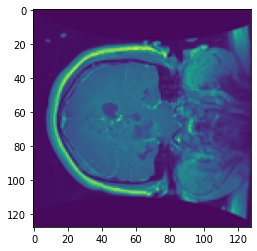

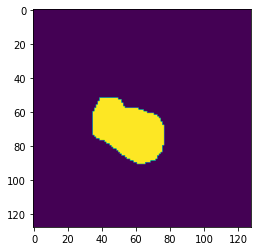

2
375


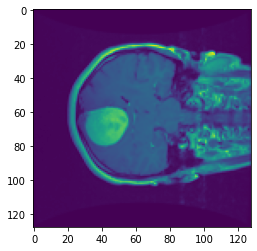

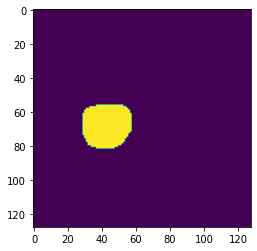

1
1659


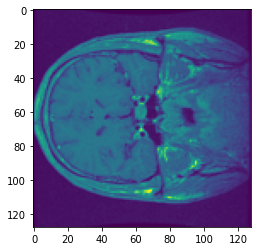

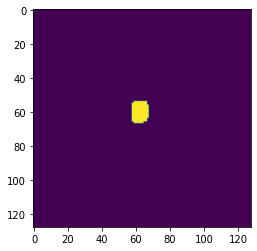

3
319


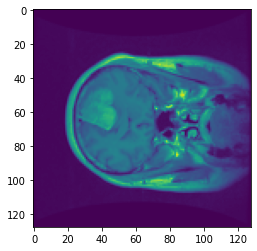

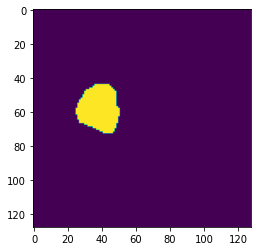

1
1428


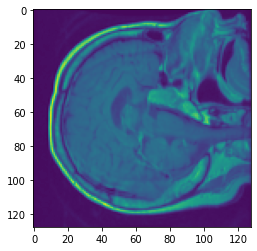

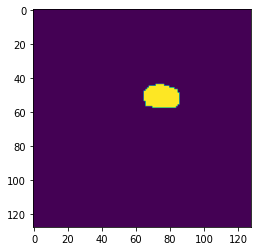

3
1827


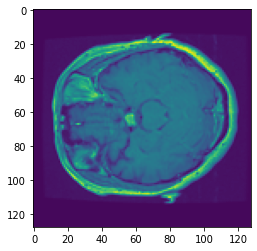

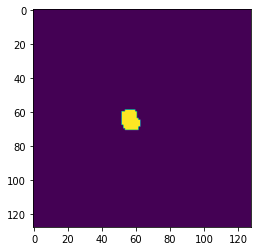

3
2088


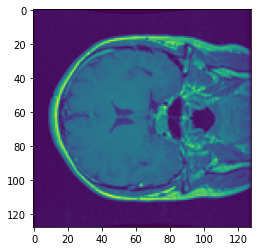

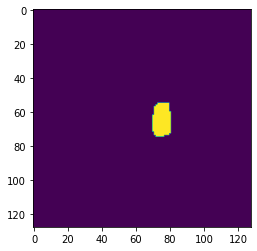

3
1308


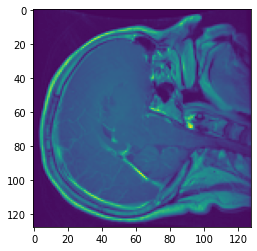

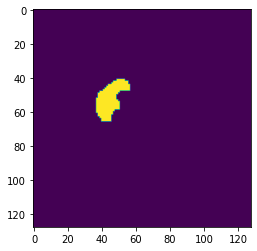

2
1351


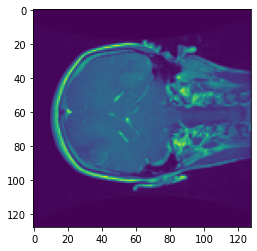

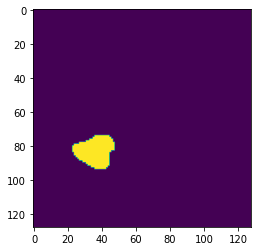

2
1850


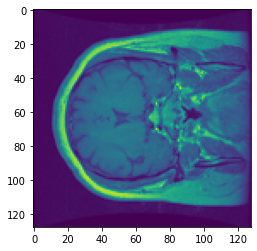

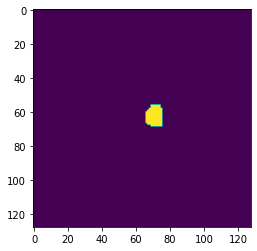

3


In [ ]:
for i in range(10):
  thing=random.randint(0,2124)
  print(thing)
  plt.imshow(fullset_x[thing].reshape((128,128)))
  plt.show()
  plt.imshow(fullset_y[thing].reshape((128,128)))
  plt.show()
  print(fullset_lab[thing])

#One hot Encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd
# creating one hot encoder object with categorical feature 0
# indicating the first column
df=pd.DataFrame(fullset_lab)
columnTransformer = ColumnTransformer([('encoder',
                                        OneHotEncoder(),
                                        [0])],
                                      remainder='passthrough')
  
tota_encoded = np.array(columnTransformer.fit_transform(df), dtype =np.int)
tota_encoded.shape

(2124, 3)

In [ ]:
print(tota_encoded)

[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [0 0 1]
 [0 0 1]
 [0 0 1]]


In [ ]:
print(np.count_nonzero(fullset_lab == 1),'1')
print(np.count_nonzero(fullset_lab == 2),'2')
print(np.count_nonzero(fullset_lab == 3),'3')

708 1
708 2
708 3


In [ ]:
from keras.utils import to_categorical
total_encoded_v2 = to_categorical(fullset_lab)
total_encoded_v2

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
np.unique(total_encoded_v2,axis=0)

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]], dtype=float32)

#Working modelv2

In [ ]:
from keras.models import Model, load_model
from keras.layers import Dense
from keras.layers import Flatten

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

d1 = Flatten()(c5)
d2 = Dense(512,activation='relu')(d1)
d3 = Dense(256,activation='relu')(d2)
output2 = Dense(4,activation='softmax')(d3)

output1 = Conv2D(1, (1, 1), activation='sigmoid') (c9)
model = Model(inputs=[inputs], outputs=[output1,output2])

model.compile(optimizer='adam', loss=['binary_crossentropy','categorical_crossentropy'],metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 160         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 128, 128, 16) 0           conv2d_19[0][0]                  
____________________________________________________________________________________________

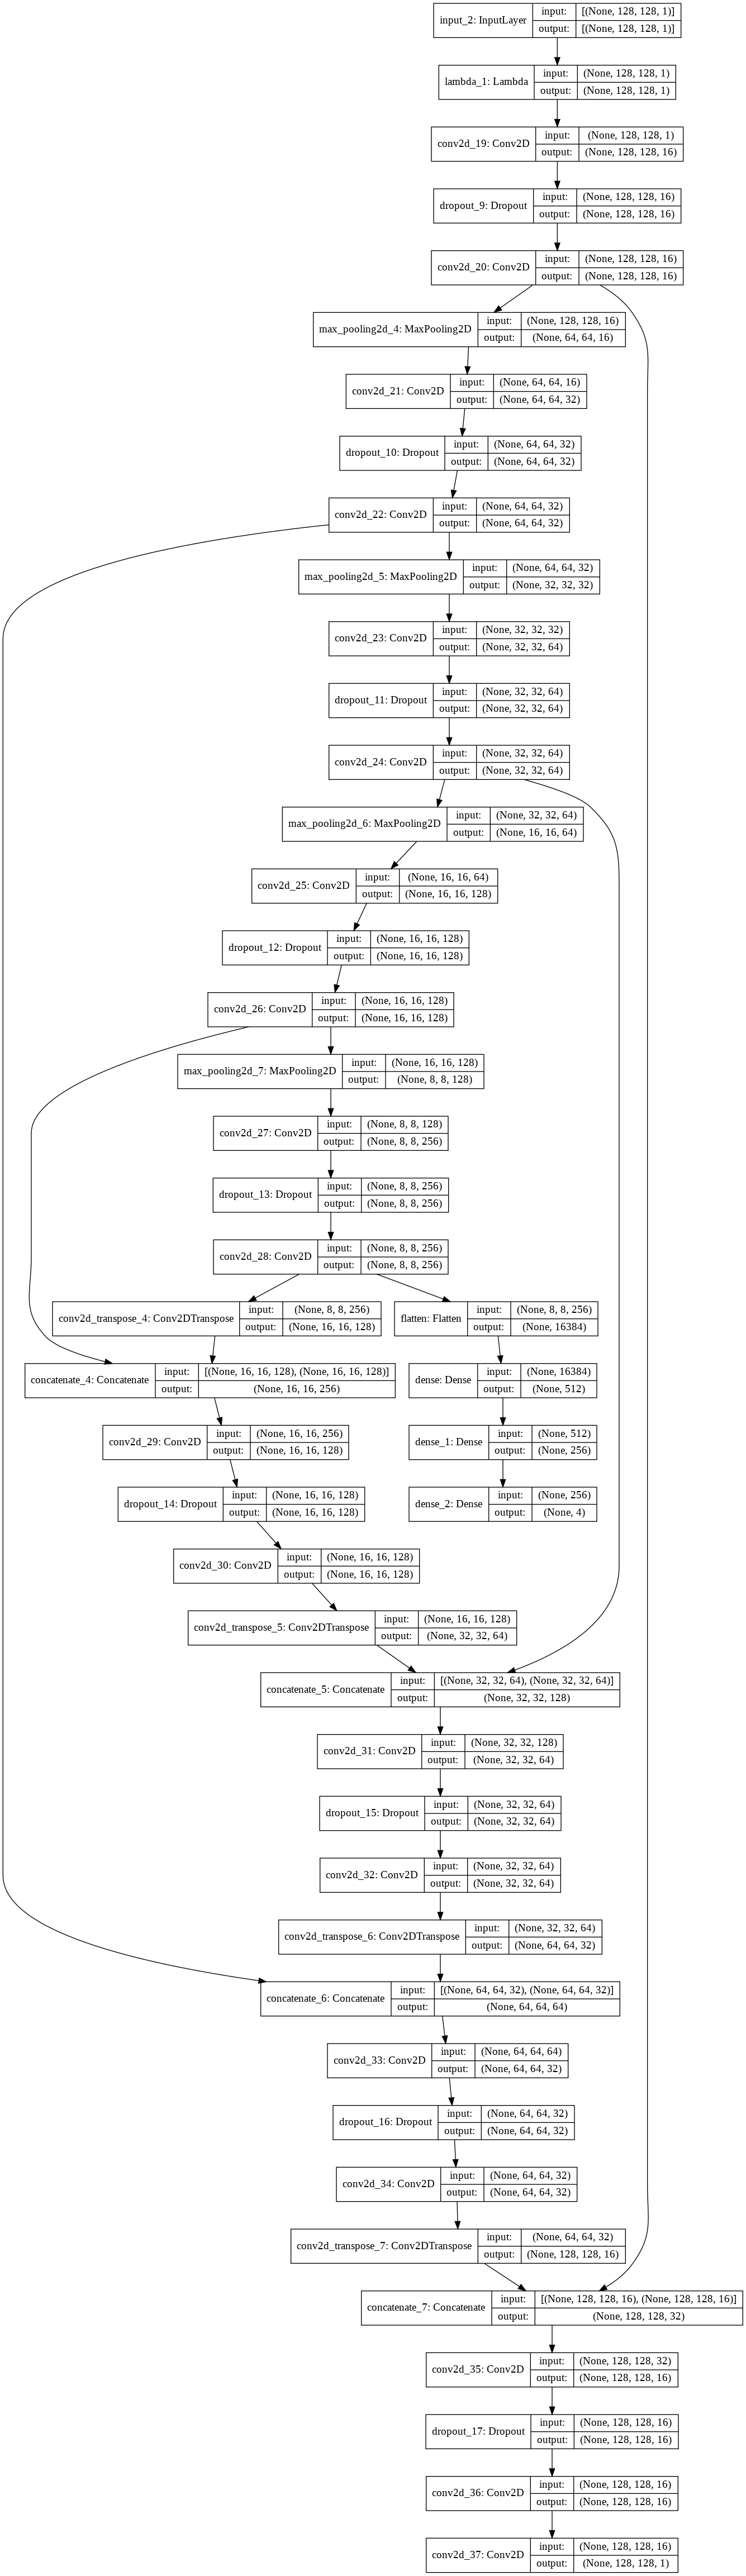

In [ ]:
import keras

# plot the model architecture
keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
)



In [ ]:
filepath = "model_main.h5"

earlystopper = EarlyStopping(patience=7, verbose=1)

#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
#                             save_best_only=True, mode='min')

callbacks_list = [earlystopper]#, checkpoint]

history = model.fit(fullset_x, [fullset_y,total_encoded_v2], validation_split=0.1, batch_size=16, epochs=50,shuffle=True, 
                    callbacks=callbacks_list)

Epoch 1/50
120/120 [==============================] - 18s 126ms/step - loss: 11.5776 - conv2d_37_loss: 0.3119 - dense_2_loss: 11.2658 - conv2d_37_accuracy: 0.9217 - dense_2_accuracy: 0.4298 - val_loss: 1.5494 - val_conv2d_37_loss: 0.0624 - val_dense_2_loss: 1.4870 - val_conv2d_37_accuracy: 0.9854 - val_dense_2_accuracy: 0.5915
Epoch 2/50
120/120 [==============================] - 13s 113ms/step - loss: 0.8469 - conv2d_37_loss: 0.0930 - dense_2_loss: 0.7540 - conv2d_37_accuracy: 0.9733 - dense_2_accuracy: 0.6909 - val_loss: 0.2715 - val_conv2d_37_loss: 0.0634 - val_dense_2_loss: 0.2081 - val_conv2d_37_accuracy: 0.9849 - val_dense_2_accuracy: 0.9155
Epoch 3/50
120/120 [==============================] - 14s 113ms/step - loss: 0.7377 - conv2d_37_loss: 0.0815 - dense_2_loss: 0.6562 - conv2d_37_accuracy: 0.9748 - dense_2_accuracy: 0.7378 - val_loss: 0.9591 - val_conv2d_37_loss: 0.0604 - val_dense_2_loss: 0.8987 - val_conv2d_37_accuracy: 0.9830 - val_dense_2_accuracy: 0.6573
Epoch 4/50
120/12

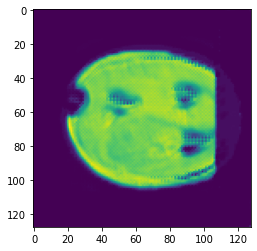

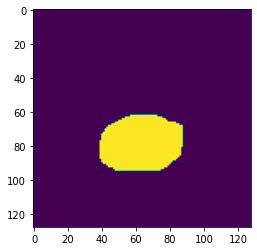

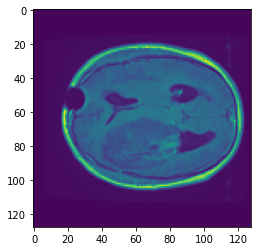

array([0.        , 0.08992638, 0.71694773, 0.19312586], dtype=float32)

In [ ]:
rs=model.predict(set_2x[0:100])
plt.imshow(rs[0][33].reshape((128,128)))
plt.show()
plt.imshow(set_2y[33].reshape((128,128)))
plt.show()
plt.imshow(set_2x[33].reshape((128,128)))
plt.show()
rs[1][45]

#We have seen that the set2 is performing not much good. so we have to improve it. Oversampling

In [ ]:
print(np.count_nonzero(label == 1),'1')
print(np.count_nonzero(label == 2),'2')
print(np.count_nonzero(label == 3),'3')

708 1
1426 2
930 3


In [ ]:
new_set_1_x=set_1x
new_set_1_y=set_1y
new_set_1_x=np.concatenate((new_set_1_x,set_1x),axis=0)
new_set_1_y=np.concatenate((new_set_1_y,set_1y),axis=0)
labels_1=labels_tot1
labels_1=np.concatenate((labels_1,labels_tot1),axis=0)
new_set_2_x=set_2x
new_set_2_y=set_2y
labels_2=labels_tot2
new_set_3_x=set_3x
new_set_3_y=set_3y
new_set_3_x=np.concatenate((new_set_3_x,set_3x[0:496]),axis=0)
new_set_3_y=np.concatenate((new_set_3_y,set_3y[0:496]),axis=0)
labels_3=labels_tot3
labels_3=np.concatenate((labels_3,labels_tot3[0:496]),axis=0)
fullset_x=np.concatenate((new_set_1_x,new_set_2_x,new_set_3_x),axis=0)
fullset_y=np.concatenate((new_set_1_y,new_set_2_y,new_set_3_y),axis=0)
fullset_lab=np.concatenate((labels_1,labels_2,labels_3),axis=0)
fullset_y.shape

(4268, 128, 128, 1)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd
# creating one hot encoder object with categorical feature 0
# indicating the first column
df=pd.DataFrame(fullset_lab)
columnTransformer = ColumnTransformer([('encoder',
                                        OneHotEncoder(),
                                        [0])],
                                      remainder='passthrough')
  
tota_encoded = np.array(columnTransformer.fit_transform(df), dtype =np.int)
tota_encoded.shape

(4268, 3)

In [ ]:
print(tota_encoded)

[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [0 0 1]
 [0 0 1]
 [0 0 1]]


In [ ]:
print(np.count_nonzero(fullset_lab == 1),'1')
print(np.count_nonzero(fullset_lab == 2),'2')
print(np.count_nonzero(fullset_lab == 3),'3')

1416 1
1426 2
1426 3


In [ ]:
from keras.utils import to_categorical
total_encoded_v2 = to_categorical(fullset_lab)
total_encoded_v2

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
np.unique(total_encoded_v2,axis=0)

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]], dtype=float32)

#oversampled Testing

In [ ]:
from keras.models import Model, load_model
from keras.layers import Dense
from keras.layers import Flatten

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

d1 = Flatten()(c5)
d2 = Dense(512,activation='relu')(d1)
d3 = Dense(256,activation='relu')(d2)
output2 = Dense(4,activation='softmax')(d3)

output1 = Conv2D(1, (1, 1), activation='sigmoid') (c9)
model = Model(inputs=[inputs], outputs=[output1,output2])

model.compile(optimizer='adam', loss=['binary_crossentropy','categorical_crossentropy'],metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128, 128, 1)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 128, 128, 16) 160         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 128, 128, 16) 0           conv2d_38[0][0]                  
____________________________________________________________________________________________

In [ ]:
'''import keras

# plot the model architecture
keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
)'''



"import keras\n\n# plot the model architecture\nkeras.utils.plot_model(\n    model,\n    to_file='model.png',\n    show_shapes=True,\n    show_layer_names=True,\n    rankdir='TB',\n    expand_nested=False,\n    dpi=96,\n)"

In [ ]:
filepath = "model_main.h5"

earlystopper = EarlyStopping(patience=7, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, 
                             save_best_only=True, mode='min')

callbacks_list = [earlystopper, checkpoint]

history = model.fit(fullset_x, [fullset_y,total_encoded_v2], validation_split=0.1, batch_size=16, epochs=50,shuffle=True, callbacks=callbacks_list)

Epoch 1/50
241/241 [==============================] - 31s 119ms/step - loss: 8.4469 - conv2d_56_loss: 0.1617 - dense_5_loss: 8.2852 - conv2d_56_accuracy: 0.9591 - dense_5_accuracy: 0.4371 - val_loss: 0.0660 - val_conv2d_56_loss: 0.0628 - val_dense_5_loss: 0.0032 - val_conv2d_56_accuracy: 0.9844 - val_dense_5_accuracy: 1.0000

Epoch 00001: loss improved from inf to 3.04691, saving model to model_main.h5
Epoch 2/50
241/241 [==============================] - 27s 112ms/step - loss: 0.8199 - conv2d_56_loss: 0.0814 - dense_5_loss: 0.7385 - conv2d_56_accuracy: 0.9734 - dense_5_accuracy: 0.6949 - val_loss: 0.3495 - val_conv2d_56_loss: 0.0479 - val_dense_5_loss: 0.3016 - val_conv2d_56_accuracy: 0.9856 - val_dense_5_accuracy: 0.9251

Epoch 00002: loss improved from 3.04691 to 0.72260, saving model to model_main.h5
Epoch 3/50
241/241 [==============================] - 27s 113ms/step - loss: 0.6051 - conv2d_56_loss: 0.0745 - dense_5_loss: 0.5306 - conv2d_56_accuracy: 0.9759 - dense_5_accuracy: 0.7

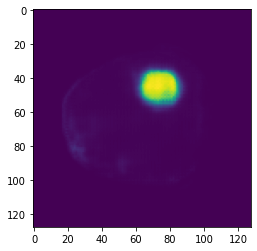

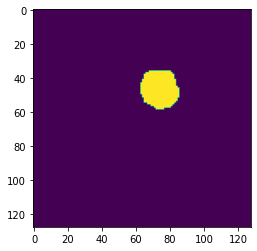

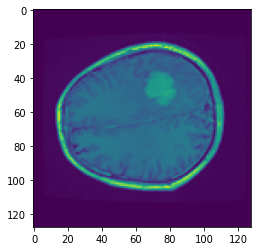

array([5.6342051e-13, 6.6608638e-01, 3.3361664e-01, 2.9695354e-04],
      dtype=float32)

In [ ]:
rs=model.predict(set_1x[0:100])
plt.imshow(rs[0][99].reshape((128,128)))
plt.show()
plt.imshow(set_1y[99].reshape((128,128)))
plt.show()
plt.imshow(set_1x[99].reshape((128,128)))
plt.show()
rs[1][99]

In [ ]:
model.save('model_final.h5')